# Import Section

## modules

In [477]:
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string 
import numpy as np
from PIL import Image

from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('wordnet')
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import re
from textblob import TextBlob, Word
from sklearn.svm import LinearSVC
from nltk.stem import PorterStemmer
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
import scipy

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johannesebert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Import Data 

On kaggle two datasets had been shared. First a list of the episodes and second the scripts for all episodes. 

In [478]:
df_episodes = pd.read_csv("southpark_episodes.csv")
df_scripts = pd.read_csv("southpark_lines.csv")

# Data Cleaning

## df_episodes

The episodes dataframe includes the following information for each episode:
   - Title
   - Air Date
   - Code 
   - Number of episode overall seasons (309 in total)
   - description
   - Season nr. (24 different season)
   - episode nr. within season

In [479]:
df_episodes.head()

,Title,Air Date,Code,#,Description,Season,Episode
0,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1
1,Weight Gain 4000,"August 20, 1997",102,2,When Cartman's environmental essay wins a nati...,1,2
2,Volcano,"August 27, 1997",103,3,A weekend trip to experience the finer points ...,1,3
3,Big Gay Al's Big Gay Boat Ride,"September 3, 1997",104,4,"When Stan discovers his new dog Sparky is gay,...",1,4
4,An Elephant Makes Love to a Pig,"September 10, 1997",105,5,"Kyle's mom won't let him keep his new pet, an ...",1,5


**Rename columns**

In [480]:
df_episodes.columns=['title', 'air_date', 'code', '#', 'description', 'season', 'episode']

In [481]:
df_episodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        309 non-null    object
 1   air_date     309 non-null    object
 2   code         309 non-null    int64 
 3   #            309 non-null    int64 
 4   description  309 non-null    object
 5   season       309 non-null    int64 
 6   episode      309 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 17.0+ KB


## df_scripts

The scripts dataframe includes the following information:
   - Title:     Title of the Episode linked to the included line
   - Character: Name of the character which said the line
   - Line:      the actual line of the character


In [482]:
df_scripts.head()

,Title,Character,Line
0,Cartman Gets an Anal Probe,Scene Description,At the bus stop.
1,Cartman Gets an Anal Probe,The Boys,"School days, school days, teacher's golden ru..."
2,Cartman Gets an Anal Probe,Kyle Broflovski,"Ah, damn it! My little brother's trying to fol..."
3,Cartman Gets an Anal Probe,Ike Broflovski,Eat banana.
4,Cartman Gets an Anal Probe,Kyle,"Ike, you can't come to school with me. [Ike Ch..."


**Rename columns**

In [483]:
df_scripts.columns = ['title', 'character', 'line']

In [484]:
df_scripts.describe()

,title,character,line
count,95320,95320,95308
unique,309,4698,89169
top,Clubhouses,Cartman,What?
freq,609,11307,374


The script dataframe includes 95320 different lines from 309 different episodes. From a first look it seems that 4698 character are included and apparently the most lines are spoken by Cartman. But we will have a closer look at the specifications of the characters. 

In [485]:
df_scripts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95320 entries, 0 to 95319
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      95320 non-null  object
 1   character  95320 non-null  object
 2   line       95308 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


Within the line column are some empty lines included. I will excludes these from the dataset:

In [486]:
df_scripts = df_scripts[df_scripts["line"].notnull()]

### Cleaning character names

Within the Charcter column we can see that some of them are described as "Scene Describtion" these are just descriptions about the scene and I will exclude them. 

In [487]:
df_scripts = df_scripts[df_scripts["character"] != "Scene Description"]

Within the character column further adjustments are needed: 

1) Sometimes a line is said by several characters. Whenevr this is the case the "charcter" column include all the applicable first names (for example: "Kyle, Stan, Cartman"). As i would like to allocate these lines also to the characters i will only include the first names for the four main characters Kyle, Stan, Cartman and Kenny.
2) For some of the characters are different names used.For example "Eric Cartman" and "Cartman". Especially for the main Characters I will adjust this 

In [488]:
character_dict = {
    "Eric Cartman" : "Eric",
    "Kyle Broflovski" : "Kyle",
    "Stan Marsh" : "Stan",
    "Kenny McCormick": "Kenny",
    "Ike Broflovski" : "Ike",
    "Mr. Herbert Garrison": "Mr. Garrison", 
    'Jerome "Chef" McElroy': "Chef",
    "Ms. Veronica Crabtree": "Ms. Crabtree",
    "Farmer Carl Denkins" : "Farmer Carl",
    "Mr. Herbert Garrison": "Mr. Garrison",
    "Wendy Testaburger": "Wendy",
    "Liane Cartman" : "Liane",
    "Clyde Donovan" : "Clyde",
    "Bebe Stevens": "Bebe",
    "Jimbo Kern" : "Jimbo",
    "Geraldo Rivera": "Geraldo",
    "Ned Gerblansky": "Ned",
    "Randy Marsh": "Randy",
    "Jesus Christ": "Jesus",
    "Frank Hammond": "Frank",
    "Richard Stamos": "Richard",
}

In [489]:
df_scripts["character"] = df_scripts["character"].replace(character_dict, regex=True)
df_scripts["character"] = df_scripts["character"].str.lower()

In [490]:
df_scripts["character"].value_counts().head(10)

cartman         11305
stan             8366
kyle             7904
randy            3494
butters          3061
mr. garrison     1221
sharon           1051
kenny            1008
chef              967
gerald            965
Name: character, dtype: int64

Looking at the amounts of line spoken by each character wen can see that the 3 main characters Cartman, Stan and Kyle are also have the most lines spoken. Within my classification I also would like to include Kenny. Unfortunately he has not spoken that many lines within the show. Later we will see if the classifier will be able to identify him. 

### Cleaning script column

First i will prepare some general cleaning of the line column. 

In [491]:
# replace everythin within "[]" as these are just scene describtions
df_scripts["line"] = df_scripts["line"].replace(r"\[.*?]", "", regex = True)

In [492]:
def clean_line(text):
    #lower the complete text
    text = text.lower()
    #replace some strings which are not correct or difficult to interpretate
    text = re.sub(r"in'", "ing", text)
    text = re.sub(r"m'kay", "mkay", text)
    #remove stopwords
    word_list = text.split()
    word_list = [w for w in word_list if w not in stopwords]
    text = " ".join(word_list)
    # remove punctation
    text = re.sub(r"[^a-z ]", "", text)
    return text

In [493]:
df_scripts["line"] = df_scripts["line"].apply(clean_line)

## Lemmatization

To reduce different tenses of same words I will use Lemmatization. The text of each character will afterwards be much normalized.

I realized that the Lemmatization is replacing the name "Butters" with "butter" because of this i included an exceptions for the name.

In [494]:
w = nltk.WordNetLemmatizer()
def lemmatization(text):
    word_list = text.split()
    text_lemma = [w.lemmatize(word) if word != "butters" else "butters" for word in word_list]
    return " ".join(text_lemma)

In [495]:
df_scripts["line"] = df_scripts["line"].apply(lambda x: lemmatization(x))

# Word clouds

I would like to have a look at the overall words used within southpark and also from single characters.

In [496]:
def create_wordcloud(data, character=""):
    if character == "":
        df_temp = data
        mask = None
        colors = None 
    else:
        df_temp = data[data["character"] == character]
        #im = Image.open(BytesIO(get(img_dict[character]).content))
        mask = np.array(Image.open(f"{character.lower()}_img.png"))
        colors = ImageColorGenerator(mask) # creates colours out of the original picture
    txt = " ".join(df_temp["line"].values)
    
    fig, ax = plt.subplots(figsize = (15, 15))
    wc = WordCloud(background_color = "black", 
                max_words = 100, 
                mask = mask,
                color_func = colors,
                stopwords = stopwords,
                width = 1000, 
                height = 1000,
                collocations = True, #bigrams
                contour_color = 'white',
                contour_width = 1,
                normalize_plurals = False, #For the name "Butters"
                min_word_length = 3,
                random_state = 42).generate(txt)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if character == "":
        plt.savefig("wordcloud"+"total" + ".png")
    else:    
        plt.savefig("wordcloud"+character + ".png")
    plt.show()

## Overall Wordcloud

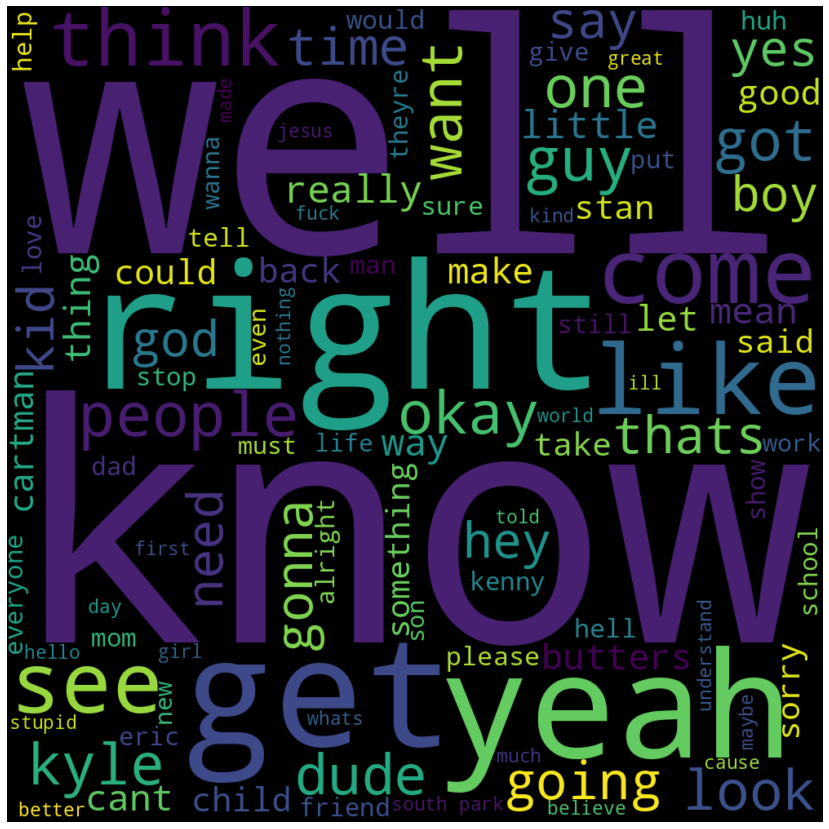

In [497]:
create_wordcloud(df_scripts)

## Cartman wordcloud

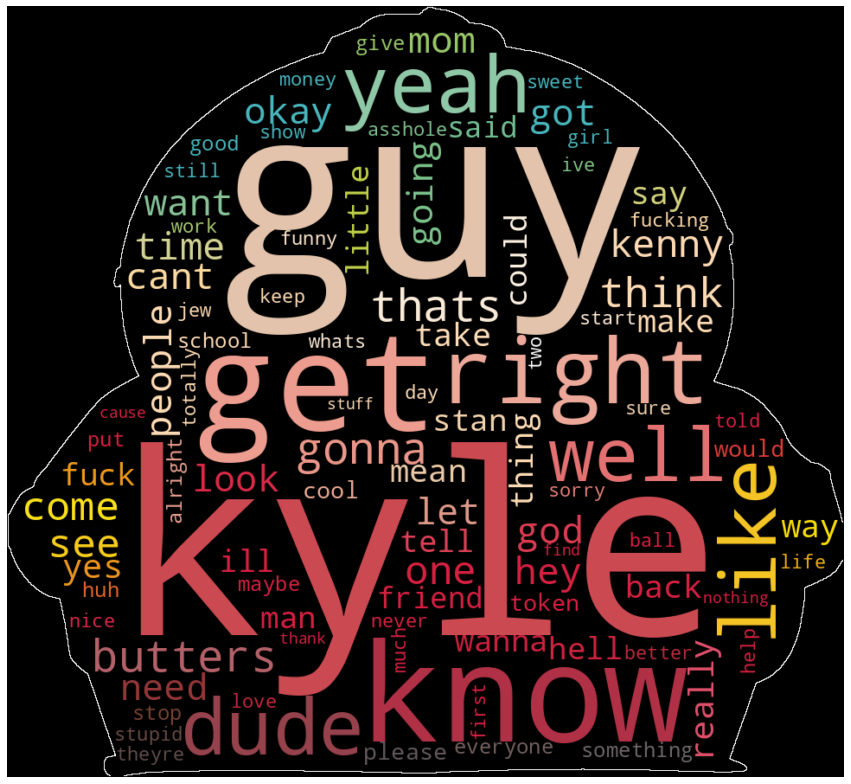

In [498]:
create_wordcloud(df_scripts, "cartman")

## Kyle Wordcloud

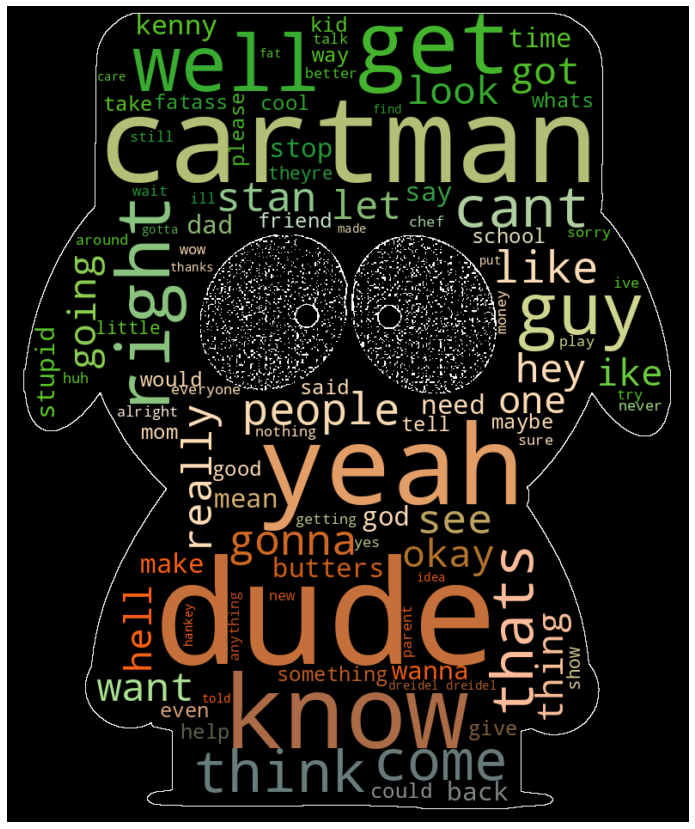

In [499]:
create_wordcloud(df_scripts, "kyle")

## Stan Wordcloud

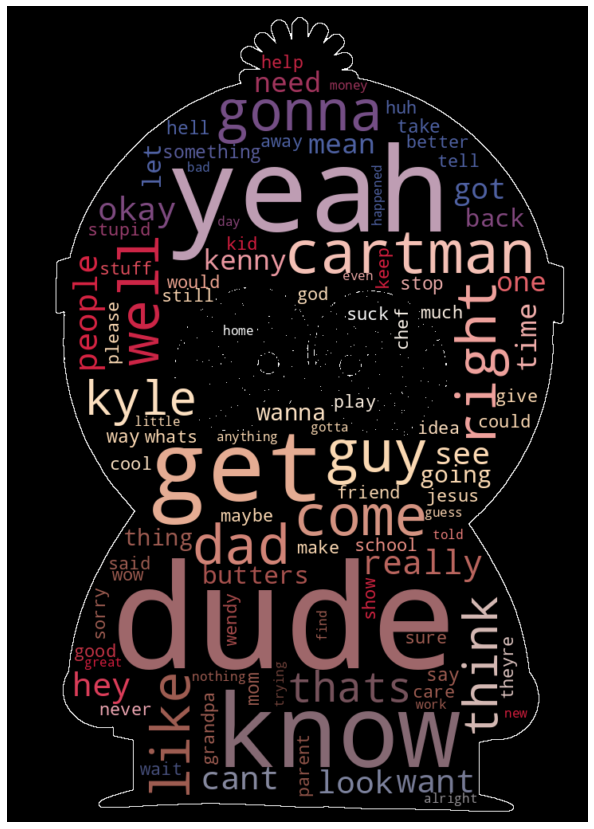

In [500]:
create_wordcloud(df_scripts, "stan")

## Kenny Wordcloud

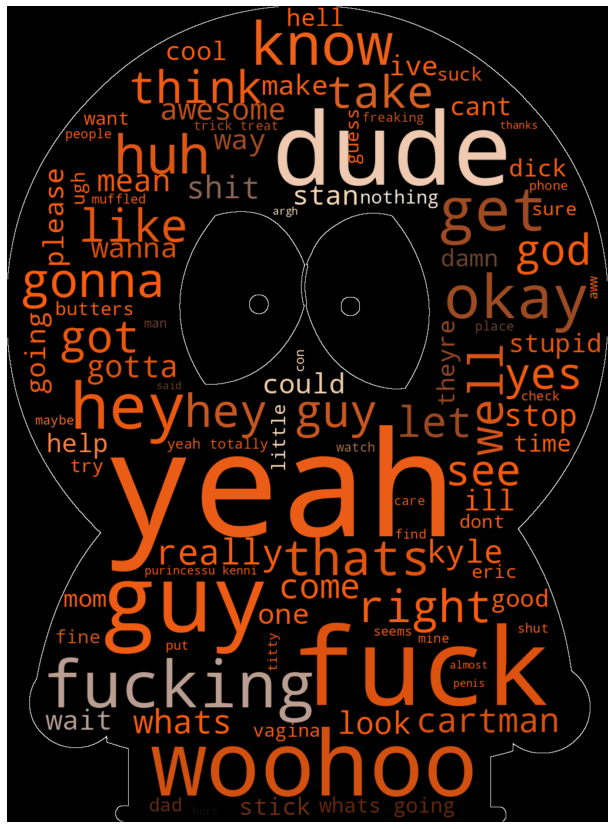

In [501]:
create_wordcloud(df_scripts, "kenny")

# Exploratory Data Analysis 

In [503]:
df_scripts

,title,character,line
1,Cartman Gets an Anal Probe,the boys,school day school day teacher golden ru
2,Cartman Gets an Anal Probe,kyle,ah damn it little brother trying follow school...
3,Cartman Gets an Anal Probe,ike,eat banana
4,Cartman Gets an Anal Probe,kyle,ike cant come school me
5,Cartman Gets an Anal Probe,eric,yeah go home little dildo
...,...,...,...
95314,South ParQ Vaccination Special,clyde,hey cartman
95315,South ParQ Vaccination Special,cartman,yeah
95316,South ParQ Vaccination Special,clyde,dude theyre reopening casa bonita weekend wann...
95317,South ParQ Vaccination Special,cartman,casa bonita hell yeah ill come oh wait cant fu...


## Amount of lines per character 

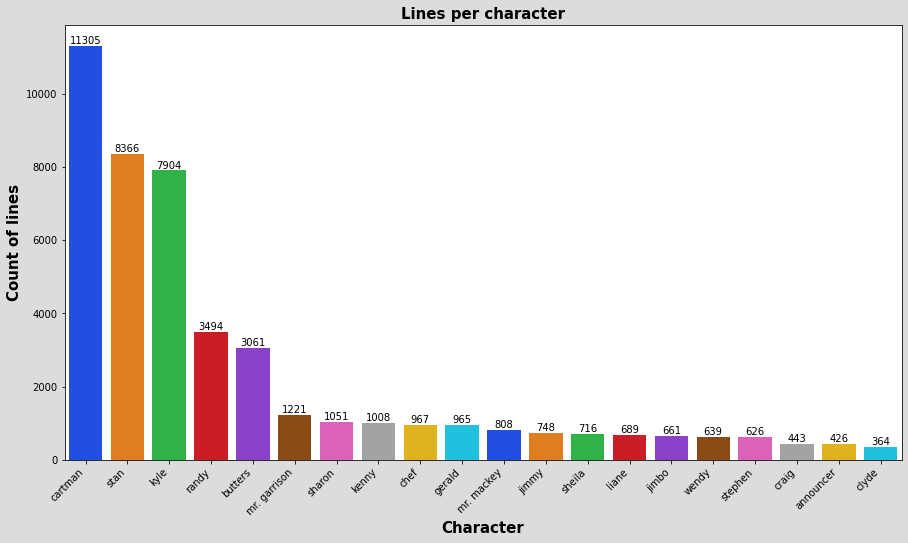

In [504]:
fig,ax = plt.subplots(figsize=(15,8),facecolor='#dcdcdc')
plt.title('Lines per character', fontsize=15, weight='bold')
df_temp = df_scripts.groupby("character").count().sort_values("title", ascending=False).head(20)
ax = sns.barplot(y=df_temp.title, x=df_temp.index, palette="bright")
ax.set_xlabel("Character",fontsize=15, weight='bold')
ax.set_ylabel("Count of lines",fontsize=15, weight='bold')
ax.set_xticklabels(labels=df_temp.index, rotation=45, ha='right')
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig("lines_per_character.png")
plt.show();

As expected the first persons with the most lines are also three of the main characters: Cartman, Stan and Kyle. The fourth main character Kenny can only be found on the 8th place. For people who know the tv-show this is not surprising as Kenny is not saying much all the time. I will be interesting to see if the few lines from Kenny will be enough for the models to identify lines from Kenny. 

## Words per character

Now that we checked the amount of lines per character i also want to have a closer look at the total words of the character. We can see above that Cartman has the most lines within the script but it could be that he is saying less words than Stan if he has always very short lines. 

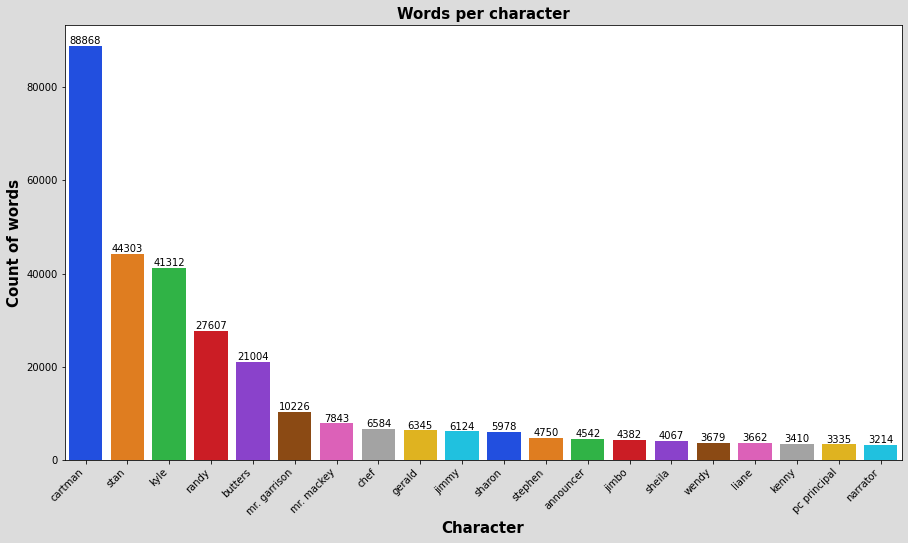

In [505]:
df_temp = pd.DataFrame.copy(df_scripts[["character","line"]])
df_temp["amount_of_words"] = df_temp['line'].str.split().apply(len)
df_temp = df_temp[["character","amount_of_words"]].groupby("character").sum().sort_values("amount_of_words",ascending=False).head(20)

fig,ax = plt.subplots(figsize=(15,8),facecolor='#dcdcdc')
plt.title('Words per character', fontsize=15, weight='bold')
ax = sns.barplot(y=df_temp.amount_of_words, x=df_temp.index, palette="bright")
ax.set_xlabel("Character",fontsize=15, weight='bold')
ax.set_ylabel("Count of words",fontsize=15, weight='bold')
ax.set_xticklabels(labels=df_temp.index, rotation=45, ha='right')
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig("words_per_character.png")
plt.show();

Cartman, Stan and Kyle are also having the most words. Also we can see that Cartman has by far the most words within the show. Within the lines overview Kenny was listed on position 8th. Within the overview of the words he has fallen back to position 18. This will make it probably even harder for the models.

## Sentiment Analysis 

Python sentiment analysis is a methodology for analyzing a piece of text to discover the sentiment hidden within it.  Sentiment analysis allows you to examine the feelings expressed in a piece of text. I want to see if it can also identify if specific characters are more negative than others. 
As a result i will include two new columns:
1. polarity: This is a float within the range [-1.0, 1.0] where -1.0 is a negative polarity and 1.0 is positive.
2. Subjectivity: Subjectivity(objectivity) identification task reports a float within the range [0.0, 1.0] where 0.0 is a very objective sentence and 1.0 is very subjective.

In [506]:
sentiment = df_scripts['line'].apply(lambda x: TextBlob(x).sentiment)

In [507]:
polarity = []
subjectivity = []

for row in sentiment:
    polarity.append(row[0])
    subjectivity.append(row[1])

df_scripts['polarity'] = polarity
df_scripts['subjectivity'] = subjectivity

In [508]:
df_scripts[["polarity","subjectivity"]].mean()

polarity        0.039001
subjectivity    0.265533
dtype: float64

The overall polarity is rather positiv than negative, but only slightly. 

In [509]:
df_scripts[df_scripts["character"].isin(["kyle", "cartman", "stan", "kenny"])].groupby("character").describe()

polarity                                                 \
             count      mean       std  min  25%  50%    75%  max   
character                                                           
cartman    11305.0  0.032168  0.278913 -1.0  0.0  0.0  0.125  1.0   
kenny       1008.0  0.005148  0.256922 -1.0  0.0  0.0  0.000  1.0   
kyle        7904.0  0.016541  0.261731 -1.0  0.0  0.0  0.000  1.0   
stan        8366.0  0.025815  0.253030 -1.0  0.0  0.0  0.000  1.0   

          subjectivity                                                    
                 count      mean       std  min  25%  50%       75%  max  
character                                                                 
cartman        11305.0  0.297806  0.338266  0.0  0.0  0.1  0.577778  1.0  
kenny           1008.0  0.199429  0.320238  0.0  0.0  0.0  0.500000  1.0  
kyle            7904.0  0.234021  0.328798  0.0  0.0  0.0  0.500000  1.0  
stan            8366.0  0.225829  0.321946  0.0  0.0  0.0  0.500000  1.0

It seems that Kenny has the lowest mean subjectivity which means he is the most objective of the main characters. The polarity shows that all of them are slightly more positive and Kenny has the lowest mean polarity. But we need to keep in mind that Kenny has not many lines and words during the whole show.

In [510]:
df_temp = df_scripts.groupby("character").describe().sort_values(("polarity","mean"))
df_temp[df_temp[("polarity","count")] >100].head(10)

polarity                                                         \
             count      mean       std  min      25%  50%       75%   max   
character                                                                   
mysterion    107.0 -0.050671  0.260732 -0.8 -0.13125  0.0  0.000000  0.50   
coon         113.0 -0.037260  0.332574 -1.0 -0.18125  0.0  0.136364  0.85   
shelly       238.0 -0.028220  0.287873 -0.8  0.00000  0.0  0.000000  0.80   
tweek        333.0 -0.025917  0.200295 -1.0  0.00000  0.0  0.000000  0.50   
ike          247.0 -0.023412  0.183072 -0.9  0.00000  0.0  0.000000  0.80   
carol        109.0 -0.017680  0.299143 -1.0  0.00000  0.0  0.000000  1.00   
phillip      234.0 -0.009179  0.277614 -1.0  0.00000  0.0  0.000000  1.00   
ned          109.0 -0.003448  0.230465 -1.0  0.00000  0.0  0.000000  0.70   
timmy        268.0 -0.000746  0.012217 -0.2  0.00000  0.0  0.000000  0.00   
kenny       1008.0  0.005148  0.256922 -1.0  0.00000  0.0  0.000000  1.00   

          subjectivity                                                         
                 count      mean       std  min  25%       50%       75%  max  
character                                                                      
mysterion        107.0  0.292930  0.340175  0.0  0.0  0.066667  0.618750  1.0  
coon             113.0  0.410048  0.333917  0.0  0.0  0.481746  0.625000  1.0  
shelly           238.0  0.258347  0.356444  0.0  0.0  0.000000  0.500000  1.0  
tweek            333.0  0.135382  0.274421  0.0  0.0  0.000000  0.050000  1.0  
ike              247.0  0.122401  0.269151  0.0  0.0  0.000000  0.000000  1.0  
carol            109.0  0.280523  0.350870  0.0  0.0  0.000000  0.568182  1.0  
phillip          234.0  0.253322  0.350928  0.0  0.0  0.000000  0.524919  1.0  
ned              109.0  0.136793  0.262360  0.0  0.0  0.000000  0.000000  1.0  
timmy            268.0  0.002985  0.048868  0.0  0.0  0.000000  0.000000  0.8  
kenny           1008.0  0.199429  0.320238  0.0  0.0  0.000000  0.500000  1.0

I filtered the overview for characters which at least have 100 lines within the script. The lowest mean polarity has Mysterion (Which is the Superhero Version of Kenny in some of the episodes). Also Kenny is listed on the place 10 of the List. Out of the 4 main Characters he seems to be the one which is most negative from polarity perspective.    

**Distribution of polarity**

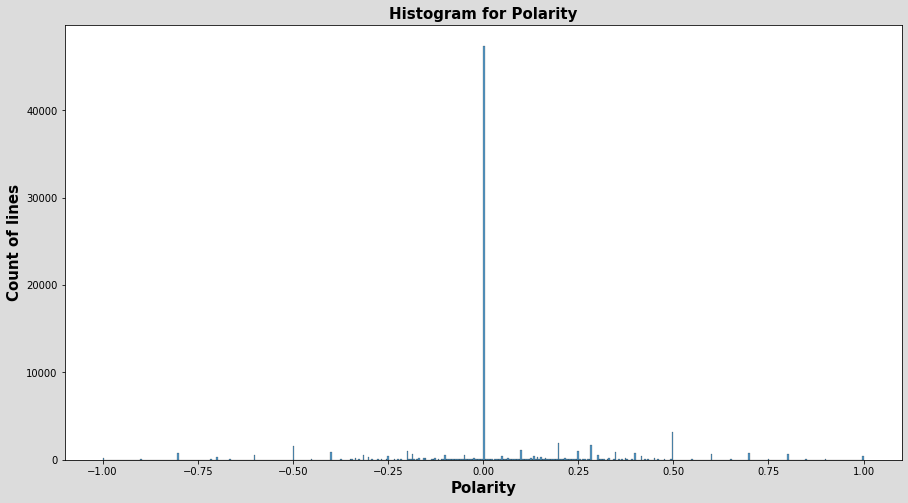

In [511]:
fig,ax = plt.subplots(figsize=(15,8),facecolor='#dcdcdc')
ax.set_xlabel("Polarity",fontsize=15, weight='bold')
ax.set_ylabel("Count of lines",fontsize=15, weight='bold')
plt.title('Histogram for Polarity', fontsize=15, weight='bold')
sns.histplot(df_scripts["polarity"],palette="bright")
plt.savefig("histogram_polarity.png")
plt.show();

**Distribution of Subjectivity**

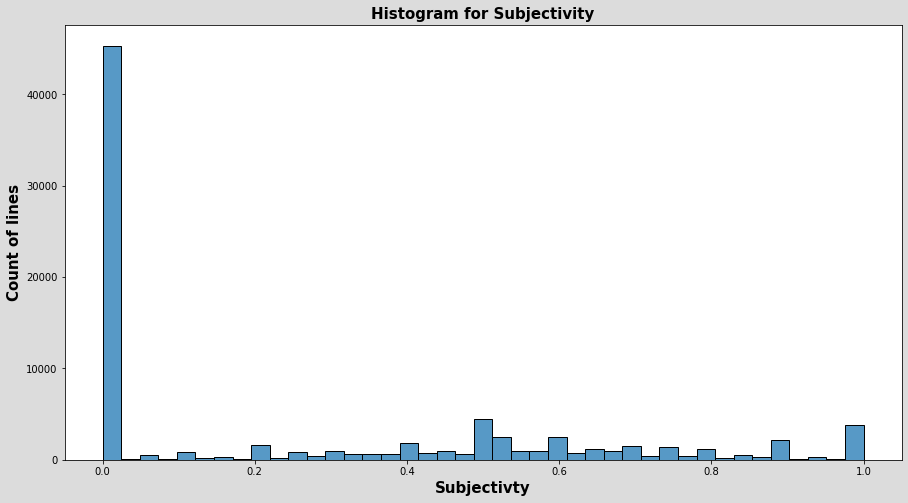

In [512]:
fig,ax = plt.subplots(figsize=(15,8),facecolor='#dcdcdc')
ax.set_xlabel("Subjectivty",fontsize=15, weight='bold')
ax.set_ylabel("Count of lines",fontsize=15, weight='bold')
plt.title('Histogram for Subjectivity', fontsize=15, weight='bold')
sns.histplot(df_scripts["subjectivity"], palette="bright")
plt.savefig("histogram_subjectivity.png")
plt.show();

# Modeling

I would like to create a model which can identify which sentence is coming from which main character. This means I will only look at the lines of Cartman, Kyle, Stan and Kenny.  

Afterwards I will filter the df_scripts data and create a new dataframe for the modeling called df_modeling. This will only include the lines which are said by the four characters, either alone or together with other people. 

In [513]:
main_characters_dict = {"cartman":0, "kyle":1, "stan":2, "kenny":3}

In [514]:
df_modeling = pd.DataFrame()
for key, value in main_characters_dict.items():
    df_temp = df_scripts.loc[df_scripts.character == key] ## adj. here
    df_temp["character_class"] = value
    df_modeling = pd.concat([df_temp, df_modeling], ignore_index = True)

/var/folders/3p/8d6w00bn0vngwxs3g0sktgmc0000gn/T/ipykernel_3232/3106803470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["character_class"] = value


## Baseline 

To evaluate the precision of the models i first will have a look at the baseline of the test data.

In [548]:
df_modeling.character.value_counts(normalize=True)

cartman    0.395515
stan       0.292691
kyle       0.276528
kenny      0.035266
Name: character, dtype: float64

By only guessing always on Cartman we would have a correct results for 39.5% of the guesses. 

The theoretical baseline based on a guessing strategy is: 

In [549]:
0.395**2 + 0.292**2 + 0.276**2 + 0.035**2

0.31869000000000003

We need to keep this in mind for the evaluation of the models. 

## Count Vectorizer

As the models cannot understand characters and words I will convert the text data to be understandable by the machine. Countvectorizer is a method to convert text to numerical data. Within this process the text will be converted into a sparse matrix.

One of the key parameters for the count vectorizer is the "ngram_range", which takes as input a tuple "(min_n, max_n)". The default is "(1, 1)". This parameter describes the lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted. All values of n such such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams. 

For my models i would like to include unigrams and bigrams so the parameter should be (1,2). Unfortunately this calculation is bringing my machine at home to its limits. After several unsuccessful attempts I decide to proceed with the following approach: 
1. Create a subset of the data which can be handled by my machine

2. Use the subset on my machine to create and test the code for the modeling.

3. After I am sure that everything is working I will rent a machine from aws to perform the modeling process on the complete dataset. 

For the modeling in the cloud I will save the cleaned modeling data set with all 4 main characters. 

In [545]:
df_modeling.to_csv("df_modeling.csv")

### Creating subset 

In [515]:
df_modeling.shape

(28583, 6)

In total there are 28583 lines for the four main characters included. I will create a subset which will include 10% of the rows from each character. 

In [516]:
df_cartman = df_modeling[df_modeling["character"] == "cartman"].sample(frac=0.05)
df_stan = df_modeling[df_modeling["character"] == "stan"].sample(frac=0.05)
df_kyle = df_modeling[df_modeling["character"] == "kyle"].sample(frac=0.05)
df_kenny = df_modeling[df_modeling["character"] == "kenny"].sample(frac=0.05)

In [517]:
df_modeling_sub = pd.concat([df_cartman, df_stan, df_kyle, df_kenny])
df_modeling_sub.reset_index(inplace=True)
df_modeling_sub.drop("index", axis=1, inplace=True)

In [518]:
df_modeling_sub.character.value_counts()

cartman    565
stan       418
kyle       395
kenny       50
Name: character, dtype: int64

In [519]:
df_modeling_sub.shape

(1428, 6)

### Countvectorizer on sub set

In [520]:
cvec = CountVectorizer(stop_words = "english", ngram_range=(1,2), max_features=1000000)
cvec.fit(df_modeling_sub["line"])
len(cvec.get_feature_names())

7105

In [521]:
df = pd.DataFrame(cvec.transform(df_modeling_sub["line"]).toarray(),
                  columns=cvec.get_feature_names())

df = df.transpose().sort_values(0, ascending=False).transpose()

## Set Target and Features 

In [522]:
y = df_modeling_sub["character_class"]
X = df

I would like to include the following additional features:
- length of the line
- polarity	
- subjectivity

I will comvert the additional features also inot soarse matrix forms

In [523]:
conv= pd.DataFrame()
conv["lenght"] = X.sum(axis=1)
conv["polarity"] = df_modeling_sub["polarity"]
conv["subjectivity"] = df_modeling_sub["subjectivity"]

In [524]:
conv_sparse = scipy.sparse.csr_matrix(conv.values)

Afterwards i will merge all of the features together

In [525]:
X = scipy.sparse.hstack((X,conv_sparse))
X.shape

(1428, 7108)

## Train test Split 

My created subsample will again be separated between train and test set to evaluate the models. 

In [528]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [537]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (1142, 7108)
y_train shape:  (1142,)
X_test shape:  (286, 7108)
y_test shape:  (286,)


In [538]:
X_train

<1142x7108 sparse matrix of type '<class 'numpy.float64'>'
	with 11730 stored elements in Compressed Sparse Row format>

## Standard Scaler

Additional I will use a stadardscaler to normalize/standardize.

In [530]:
scaler=StandardScaler(with_mean=False)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Testing Modeling locally

I will use several models combine with gridsearch to identify the best performing model. 

First I will create a dictionary with the different models and parameters for the gridsearch. For the local test run i will minimize the parameters to see if the code will work properly. 

In [531]:
model_dic = {
    1 : {"model": LogisticRegression(max_iter=8000),
         "parameters": {
                         'penalty': ['elasticnet'],
                         'solver': ['saga'],
                         'C': np.logspace(0, 3, 2),
                         "l1_ratio": np.linspace(0, 1, 2)
                         }, 
        "name" : "Logistic Regression"
        },
    2 : {"model": KNeighborsClassifier(),
         "parameters": {
                        'n_neighbors': [5,7,9,12,15],
                        'leaf_size': [5,10,20,30,40,50],
                        'weights': ["uniform","distance"]
                        },
        "name" : "KNeighbors Classifier"
        },
    3 : {"model": xgb.XGBClassifier(objective='binary:logistic', nthread=1, use_label_encoder=False),
         "parameters": {
                         "booster": ["gbtree"], 
                         'min_child_weight': [1],
                         'gamma': [0.5, 1],
                         'subsample': [0.6],
                         'colsample_bytree': [0.6],
                         'max_depth': [5, 7],
                         'n_estimators': [500],
                         'learning_rate':[0.01]
                        },
        "name" : "XGB Classifier"
        },
    4 : {"model": DecisionTreeClassifier(),
         "parameters": {
                        'max_depth': [10,20,30,40],
                        'min_samples_split': [2,4,6,8,10,12,14,16,18],
                        "min_samples_leaf" : [2,4,6,8,10,12,14,16,18],
                        
             "max_features": ["auto"]
                        },
        "name" : "Decision Tree Classifier"
        }
    
    
}

For the different models I would like to extract and save the metrics for the best moduls within a dataframe. Like this i can import the results on my local machine.

In [542]:
model_results = pd.DataFrame(columns=["name", "best_parameters","trainscore","testscore","accuracy_score","classification_report"])

The below code will iterate through the different models and extract the best models and the applicable metrics for these models. The below is the test run of the code. 

In [547]:
for i in range(1,5):
        model = model_dic[i]["model"]
        parameters = model_dic[i]["parameters"]
        name = model_dic[i]["name"],
        gridsearch = GridSearchCV(model,
                              parameters,
                              n_jobs=-1, 
                              cv=2,  
                              return_train_score=True)

        gridsearch.fit(X_train, y_train)
        best_model = gridsearch.best_estimator_
        
        
        trainscore = best_model.score(X_train, y_train)
        testscore =  best_model.score(X_test, y_test)
        predictions = best_model.predict(X_test)
        accuracy_score = metrics.accuracy_score(y_test, predictions)
        classification_report = metrics.classification_report(y_test, predictions, output_dict=True)
        metrics.plot_confusion_matrix(best_model, X_test, y_test, labels=[0, 1, 2, 3], cmap='Blues')
        plt.savefig("confusion_matrix"+ str(name) + ".png")
        
        
        model_results  = model_results.append({
                        'name': name,
                        "best_parameters": gridsearch.best_params_, 
                        "trainscore": trainscore,
                        "testscore": testscore,
                        "accuracy_score": accuracy_score,
                        "classification_report": classification_report}, 
                        ignore_index=True)

In [544]:
model_results

,name,best_parameters,trainscore,testscore,accuracy_score,classification_report
0,"(Logistic Regression,)","{'C': 1.0, 'l1_ratio': 1.0, 'penalty': 'elasti...",0.934326,0.391608,0.391608,"{'0': {'precision': 0.4666666666666667, 'recal..."
1,"(KNeighbors Classifier,)","{'leaf_size': 5, 'n_neighbors': 15, 'weights':...",0.936077,0.335664,0.335664,"{'0': {'precision': 0.49230769230769234, 'reca..."
2,"(XGB Classifier,)","{'booster': 'gbtree', 'colsample_bytree': 0.6,...",0.606830,0.444056,0.444056,"{'0': {'precision': 0.44751381215469616, 'reca..."
3,"(Decision Tree Classifier,)","{'max_depth': 10, 'max_features': 'auto', 'min...",0.410683,0.363636,0.363636,"{'0': {'precision': 0.36162361623616235, 'reca..."


The code is working. Within a next step i will set up a machine on aws to run the models on the complete data. 

## Modeling in cloud

Within a next step I will rent a machine on aws to run the models on the complete dataset. Afterwards I will present the results below. 

# Results